# Rock-Paper-Scissors Transfer Learning
Fine-tune a pretrained ResNet18 on a small Rock-Paper-Scissors dataset. We'll freeze early layers, train the final block + classifier, and visualize loss curves.

## Imports

In [10]:
import copy
import torch
import torchvision
from torchvision.transforms import v2 as transforms
from tqdm import tqdm
from rps_dataset import RockPaperScissorsDataset
from plot import plot_losses

## Device selection

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Data augmentation transform

In [12]:
def define_transform() -> transforms.Transform:
    transform_crop = transforms.RandomResizedCrop(size=(100, 100), scale=(0.5, 1.0), ratio=(1, 1))
    transform_choice = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomGrayscale(),
    ])
    return transforms.Compose([transform_crop, transform_choice, transform_choice])

## Load dataset & create splits

In [13]:
transform = define_transform()
dataset = RockPaperScissorsDataset(img_dir='rps_dataset', transform=transform)
train_set, val_set, test_set = dataset.balanced_split([0.7, 0.15, 0.15])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)
len(train_set), len(val_set), len(test_set)

(30, 6, 6)

## Initialize pretrained model & adapt classifier

In [14]:
pretrained_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model: torchvision.models.ResNet = copy.deepcopy(pretrained_model)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=3)
model.fc.reset_parameters()
# Freeze all but last conv block and classifier
for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False
model = model.to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad), 'trainable params'

(8395267, 'trainable params')

## Optimization setup

In [15]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
n_epochs = 50  # Adjust as needed
train_losses = []
val_losses = []

## Training loop

In [16]:
epoch_iter = tqdm(range(n_epochs), desc='Epochs')
for _ in epoch_iter:
    # Train
    model.train()
    train_loss_total = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        train_loss = loss_fn(y_pred, y)
        train_loss.backward()
        optimizer.step()
        train_loss_total += train_loss.item()
    # Validation
    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            val_loss = loss_fn(y_pred, y)
            val_loss_total += val_loss.item()
    avg_train = train_loss_total / len(train_set)
    avg_val = val_loss_total / len(val_set)
    train_losses.append(avg_train)
    val_losses.append(avg_val)
    epoch_iter.set_postfix(train_loss=avg_train, val_loss=avg_val)
print('Training complete.')

Epochs: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s, train_loss=0.00153, val_loss=1.1]  

Training complete.


## Plot loss curves

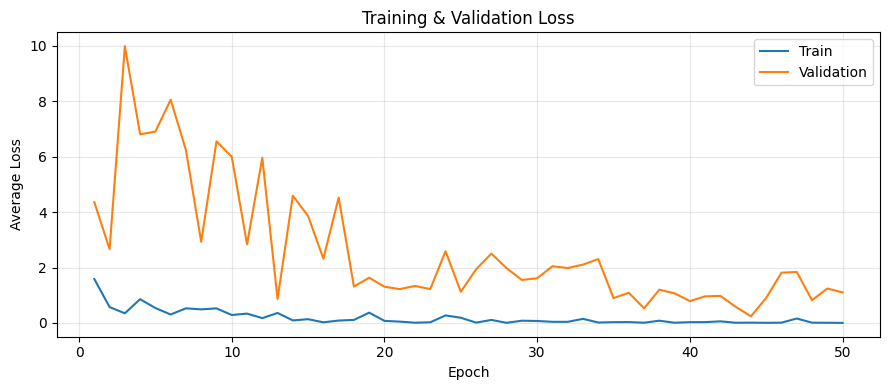

In [17]:
plot_losses(train_losses, val_losses)

## Evaluate on test set

In [18]:
model.eval()
dataset.transform = None  # disable augmentation for evaluation
with torch.no_grad():
    test_loss_total = 0.0
    test_correct_total = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss_value = loss_fn(y_pred, y)
        top_class = y_pred.argmax(dim=1)
        test_loss_total += loss_value.item()
        test_correct_total += (top_class == y).sum().item()
print(f'Final test loss: {test_loss_total / len(test_set):.4f}')
print(f'Final test accuracy: {test_correct_total / len(test_set):.4f}')

Final test loss: 0.1545
Final test accuracy: 1.0000
